In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward_pass_propgation(self, input):
        raise NotImplementedError("Subclasses must implement forward_pass_propgation() method.")

    def backward_pass_propgation(self, output_error, learning_rate):
        raise NotImplementedError("Subclasses must implement backward_pass_propgation() method.")

In [3]:
class Linear_Layer(Layer):
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.weights = np.random.randn(num_input_features, num_output_features) / np.sqrt(num_input_features)
        self.bias = np.random.rand(1, num_output_features) - 0.5

    def forward_pass_propgation(self, input_data):
        self.input = input_data
        z = np.matmul(input_data, self.weights) 
        self.output = np.add(z, self.bias) 
        return self.output
    
    def backward_pass_propgation(self, error_output_loss, lr):
        error_input_loss = np.matmul(error_output_loss, self.weights.T)

        wt_gradient = np.matmul(self.input.T, error_output_loss)
        b_gradient = np.sum(error_output_loss, axis=0, keepdims=True)

        self.weights -= lr * wt_gradient
        self.bias -= lr * b_gradient

        return error_input_loss

    def weights(self):
        print(self.weights)

In [4]:
class Sigmoid_Activation_Function(Layer):
    def __init__(self):
        self.outputs = None

    def forward_pass_propgation(self, inputs):
        self.outputs = self.sigmoid(inputs)
        return self.outputs

    def backward_pass_propgation(self, delta):
        gradient_output = np.multiply(self.outputs, np.subtract(1, self.outputs))
        return np.multiply(gradient_output, delta)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [5]:
class Activation_Function_Layer(Layer):
    def __init__(self, activation_state, activation_sensitivity):
        self.activation_state = activation_state
        self.activation_sensitivity = activation_sensitivity

    def forward_pass_propgation(self, input):
        self.input = input
        self.output = self.activation_state(self.input)
        return self.output

    def backward_pass_propgation(self, output_loss, lr):
        return self.activation_sensitivity(self.input) * output_loss


In [6]:
def calculateMeanSquaredError(targets, predictions):
    squared_errors = (targets - predictions) ** 2
    return np.mean(squared_errors)

def calculateMSEGradient(targets, predictions):
    residuals = predictions - targets
    gradient = 2 * residuals / len(targets)
    return gradient


In [7]:
class Tanh_Activation_Function(Layer):
    def __init__(self):
        self.outputs = None

    def forward_pass_propgation(self, input_values):
        return np.tanh(input_values)

    def backward_pass_propgation(self, delta):
        return 1-np.tanh(delta)**2


In [8]:
#Softmax Function
class Softmax_Activation_Function(Layer):
    def __init__(self):
        self.exp_inputs = None
        self.num_classes = None
        self.output = None

    def forward_pass_propgation(self, input_values):
        self.exp_inputs = np.exp(input_values - np.max(input_values))
        softmax_outputs = self.exp_inputs / np.sum(self.exp_inputs, axis=0, keepdims=True)
        return softmax_outputs

    def backward_pass_propgation(self, softmax_outputs, error_gradients):
        self.output = np.empty(softmax_outputs.shape)
        self.num_classes = softmax_outputs.shape[1]
        
        for cl_id in range(self.num_classes):
            jac = -(softmax_outputs * softmax_outputs[:, [cl_id]])
            jac[:, cl_id] += softmax_outputs[:, cl_id]
            self.output[:, cl_id] = np.sum(error_gradients * jac, axis=1)
        return self.output

In [9]:
def softmax(H):
    H = np.exp(H) / sum(np.exp(H))
    return H

In [10]:
class Cross_Entropy(Layer):
    def __init__(self):
        self.penalty = None
        
    def forward_pass_propgation(self, predictions, targets):
        self.penalty = -targets * np.log(predictions)
        return self.penalty
            
    def backward_pass_propgation(self, predictions, targets):
        error_gradients = targets - predictions
        return error_gradients


In [11]:
class Sequential(Layer):
    def __init__(self):
        self.layers_list = []
        self.loss_function = None
        self.loss_gradient_tensor = None
        self.weights_tensor = None

    def savingModel(self, file="NN_model.wts"):
      f = open(file, mode="wb")
      pickle.dump(self.retrieveModelWeights(), f)
      f.close()

    def loadingModel(self, file="NN_model.wts"):
        f = open(file, mode="rb")
        weights = pickle.load(f)
        f.close()
        return weights    

    def applyLossFunction(self, loss_function, loss_gradient_tensor):
        self.loss_function = loss_function
        self.loss_gradient_tensor = loss_gradient_tensor    
    
    def add(self, layer):
        self.layers_list.append(layer)

    def model_predict(self, InputData):
        neural_depth = len(InputData) 
        observed_predicted_results = []
        for i in range(neural_depth):
            neural_output = InputData[i]
            for layer in self.layers_list:
                neural_output = layer.forward_pass_propgation(neural_output)
            observed_predicted_results.append(neural_output) 
        return observed_predicted_results

    def predict(self, input_data):
        num_inputs = len(input_data)
        pred_result = []
        for i in range(num_inputs):
            output = input_data[i]
            for layer in self.layers_list:
                output = layer.forward_pass_propgation(output)
            pred_result.append(output)
        return pred_result
    
    def fit(self, x_train, y_train, epochs, lr):
        s_data_values = len(x_train)
        loss_list_model=[]
        for i in range(epochs):
            _err_total = 0
            for j in range(s_data_values):
                o_p = x_train[j]
                for l in self.layers_list:
                    o_p = l.forward_pass_propgation(o_p)

                _err_total = _err_total + self.loss_function(y_train[j], o_p)

                _err = self.loss_gradient_tensor(y_train[j], o_p)
                for l in reversed(self.layers_list):
                    _err = l.backward_pass_propgation(_err, lr)

            _err_total = _err_total / s_data_values
            loss_list_model.append(_err_total)
            if i % 5 == 0:
              print('Epoch no. %d/%d  Error = %f' % (i+1, epochs, _err_total))
        return loss_list_model

    def retrieveModelWeights(self):
      self.weights_tensor = list()
      for layer in self.layers_list:
        if isinstance(layer, Linear_Layer):
          self.weights_tensor.append(layer.weights)
          return self.weights_tensor



XOR Problem

In [12]:
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])


Model 1 using hyperbolic tangent activation functions

In [13]:

modelTan = Sequential()
modelTan.add(Linear_Layer(2, 2))
tan_model1 = Tanh_Activation_Function()
modelTan.add(Activation_Function_Layer(tan_model1.forward_pass_propgation, tan_model1.backward_pass_propgation))
modelTan.add(Linear_Layer(2, 1))
modelTan.add(Activation_Function_Layer(tan_model1.forward_pass_propgation, tan_model1.backward_pass_propgation))

modelTan.applyLossFunction(calculateMeanSquaredError, calculateMSEGradient)
modelTan.fit(x_train, y_train, epochs=100, lr=0.1)

output_model1 = modelTan.predict(x_train)
print("Predicted for model 1 Using hyperbolic TAN Activation funtion:", output_model1)

threshold = 0.5

predicted = output_model1

binary_predicted = [int(p > threshold) for p in predicted]
print(binary_predicted)

modelTan.retrieveModelWeights()

modelTan.savingModel()
optimizedXorWeights = modelTan.loadingModel()
print("Optimized weights for XOR problem:", optimizedXorWeights)


Epoch no. 1/100  Error = 2.052137
Epoch no. 6/100  Error = 0.373488
Epoch no. 11/100  Error = 0.332436
Epoch no. 16/100  Error = 0.284242
Epoch no. 21/100  Error = 0.249273
Epoch no. 26/100  Error = 0.231552
Epoch no. 31/100  Error = 0.222750
Epoch no. 36/100  Error = 0.217647
Epoch no. 41/100  Error = 0.214217
Epoch no. 46/100  Error = 0.211663
Epoch no. 51/100  Error = 0.209615
Epoch no. 56/100  Error = 0.207881
Epoch no. 61/100  Error = 0.206355
Epoch no. 66/100  Error = 0.204971
Epoch no. 71/100  Error = 0.203687
Epoch no. 76/100  Error = 0.202470
Epoch no. 81/100  Error = 0.201291
Epoch no. 86/100  Error = 0.200120
Epoch no. 91/100  Error = 0.198923
Epoch no. 96/100  Error = 0.197660
Predicted for model 1 Using hyperbolic TAN Activation funtion: [array([[0.04524562]]), array([[0.65285595]]), array([[0.63775228]]), array([[0.65242614]])]
[0, 1, 1, 1]
Optimized weights for XOR problem: [array([[-0.94905951,  1.48402253],
       [-0.90360726,  1.61428709]])]


In [14]:
acc_for_Model1 = accuracy_score([0,1,1,0], binary_predicted)

print("Accuracy Model 1 (hyperbolic tangent activations) : " ,acc_for_Model1)

Accuracy Model 1 (hyperbolic tangent activations) :  0.75


Model 2 using Sigmoid Activation fucntions

In [15]:

modelSig = Sequential()
modelSig.add(Linear_Layer(2, 2))
sig_model2 = Sigmoid_Activation_Function()
modelSig.add(Activation_Function_Layer(sig_model2.forward_pass_propgation, sig_model2.backward_pass_propgation))
modelSig.add(Linear_Layer(2, 1))
modelSig.add(Activation_Function_Layer(sig_model2.forward_pass_propgation, sig_model2.backward_pass_propgation))

modelSig.applyLossFunction(calculateMeanSquaredError, calculateMSEGradient)
modelSig.fit(x_train, y_train, epochs=1000, lr=0.1)

output_model2 = modelSig.predict(x_train)
print("Predicted for model 2 Using Sigmoid Activation funtion:", output_model2)

threshold = 0.5
predicted = output_model2
binary_predicted = [int(p > threshold) for p in predicted]
print(binary_predicted)

modelSig.retrieveModelWeights()

modelSig.savingModel()
optimizedXorWeights = modelSig.loadingModel()
print("Optimized weights for XOR problem:", optimizedXorWeights)
acc_for_Model2 = accuracy_score([0,1,1,0], binary_predicted)

print("Accuracy Model 2 (sigmoid activations) : " ,acc_for_Model2)

Epoch no. 1/1000  Error = 0.349187
Epoch no. 6/1000  Error = 0.306857
Epoch no. 11/1000  Error = 0.282316
Epoch no. 16/1000  Error = 0.269713
Epoch no. 21/1000  Error = 0.263021
Epoch no. 26/1000  Error = 0.259200
Epoch no. 31/1000  Error = 0.256858
Epoch no. 36/1000  Error = 0.255337
Epoch no. 41/1000  Error = 0.254300
Epoch no. 46/1000  Error = 0.253564
Epoch no. 51/1000  Error = 0.253026
Epoch no. 56/1000  Error = 0.252622
Epoch no. 61/1000  Error = 0.252312
Epoch no. 66/1000  Error = 0.252069
Epoch no. 71/1000  Error = 0.251877
Epoch no. 76/1000  Error = 0.251723
Epoch no. 81/1000  Error = 0.251597
Epoch no. 86/1000  Error = 0.251494
Epoch no. 91/1000  Error = 0.251409
Epoch no. 96/1000  Error = 0.251339
Epoch no. 101/1000  Error = 0.251280
Epoch no. 106/1000  Error = 0.251231
Epoch no. 111/1000  Error = 0.251190
Epoch no. 116/1000  Error = 0.251156
Epoch no. 121/1000  Error = 0.251128
Epoch no. 126/1000  Error = 0.251104
Epoch no. 131/1000  Error = 0.251086
Epoch no. 136/1000  Err

When compared the activation fucntions, we can see that the hyperbolic tangent activations give a better accuracy over sigmoid activation fucntion and its easier to train. 

2) Handwritten digit (MNist)

In [16]:
from keras.datasets import mnist
from keras.utils import np_utils

In [17]:
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.1, random_state=42)


In [18]:
def preprocessMnist_X(X):
    X = X.reshape(X.shape[0], 1, 28*28) 
    X = X.astype('float32') 
    X /= 255
    return X

In [19]:
x_train = preprocessMnist_X(x_train)
x_test = preprocessMnist_X(x_test)
x_val = preprocessMnist_X(x_val)

In [20]:
y_test = np_utils.to_categorical(y_test)
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)


In [21]:
def convert_to_binary(arr):
    binary_arr = []
    for a in arr:
        max_index = np.argmax(a)
        binary = np.zeros(10)
        binary[max_index] = 1
        binary_arr.append(binary)
    return np.array(binary_arr)

In [22]:
def accuracy_MNist(y_actual, y_pred):
    y_pred_indices = np.argmax(y_pred, axis=1)
    y_actual_indices = np.argmax(y_actual, axis=1)
    correct = np.sum(y_pred_indices == y_actual_indices)
    acc = correct / len(y_actual) * 100
    return acc

Model 1 with learning rate 0.01 and hyperbolic tangent activation functions

In [23]:
mnist_model_11 = Sequential() 
tan_model_mn = Tanh_Activation_Function()
mnist_model_11.add(Linear_Layer(28*28, 100))              
mnist_model_11.add(Activation_Function_Layer(tan_model_mn.forward_pass_propgation, tan_model_mn.backward_pass_propgation)) 

mnist_model_11.add(Linear_Layer(100, 50))           
mnist_model_11.add(Activation_Function_Layer(tan_model_mn.forward_pass_propgation, tan_model_mn.backward_pass_propgation))  

mnist_model_11.add(Linear_Layer(50, 10))                 
mnist_model_11.add(Activation_Function_Layer(tan_model_mn.forward_pass_propgation, tan_model_mn.backward_pass_propgation))  


In [24]:
mnist_model_11.applyLossFunction(calculateMeanSquaredError, calculateMSEGradient)
loss11 = mnist_model_11.fit(x_train, y_train, epochs=10, lr=0.1)

mnist_model_11.retrieveModelWeights()

mnist_model_11.savingModel()
optimizedMnistWeights = mnist_model_11.loadingModel()
print("Optimized weights for Mnist problem:", optimizedMnistWeights)

Epoch no. 1/10  Error = 0.021927
Epoch no. 6/10  Error = 0.005400
Optimized weights for Mnist problem: [array([[ 0.00185288, -0.01615189, -0.03338356, ..., -0.06905435,
         0.00342254, -0.04098517],
       [-0.07673472, -0.01389846, -0.02985741, ..., -0.03493314,
        -0.05587761, -0.03196336],
       [ 0.00884413,  0.02762573, -0.02181616, ..., -0.0655666 ,
        -0.04371947,  0.03850567],
       ...,
       [-0.05765154, -0.01109967,  0.00153387, ..., -0.03538051,
        -0.02223947,  0.00805678],
       [ 0.04764852,  0.04802755,  0.01505391, ..., -0.04583054,
        -0.003717  ,  0.03513197],
       [ 0.02824673, -0.01397756, -0.00792746, ...,  0.01114813,
         0.0166381 ,  0.0022196 ]])]


Text(0.5, 0, 'Epochs')

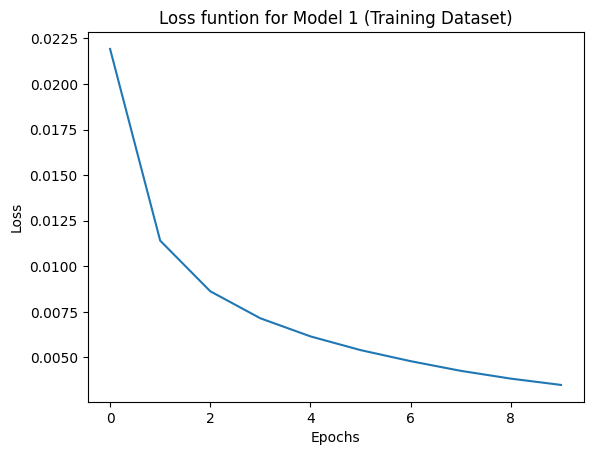

In [25]:
plt.plot(loss11)
plt.title('Loss funtion for Model 1 (Training Dataset)')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [26]:
model_pred = mnist_model_11.model_predict(x_train)
t = convert_to_binary(model_pred)
print(' Accuracy for model 1 on training dataset: ',accuracy_MNist(y_train , t))

 Accuracy for model 1 on training dataset:  98.39259259259259


Model 2 with learning rate 0.1 and tangent activation functions

In [27]:
mnist_model_12 = Sequential()  
sig_model_mn = Tanh_Activation_Function()
mnist_model_12.add(Linear_Layer(28*28, 40 ))              
mnist_model_12.add(Activation_Function_Layer(sig_model_mn.forward_pass_propgation, sig_model_mn.backward_pass_propgation)) 

mnist_model_12.add(Linear_Layer(40, 20))                 
mnist_model_12.add(Activation_Function_Layer(sig_model_mn.forward_pass_propgation, sig_model_mn.backward_pass_propgation))  

mnist_model_12.add(Linear_Layer(20, 10))                 
mnist_model_12.add(Activation_Function_Layer(sig_model_mn.forward_pass_propgation, sig_model_mn.backward_pass_propgation))  


In [28]:
mnist_model_12.applyLossFunction(calculateMeanSquaredError, calculateMSEGradient)
loss12 = mnist_model_12.fit(x_train, y_train, epochs=10, lr=0.1)

mnist_model_12.retrieveModelWeights()

mnist_model_12.savingModel()
optimizedMnistWeights = mnist_model_12.loadingModel()
print("Optimized weights for Mnist problem:", optimizedMnistWeights)

Epoch no. 1/10  Error = 0.020976
Epoch no. 6/10  Error = 0.006930
Optimized weights for Mnist problem: [array([[ 0.01564054,  0.02707454,  0.01561285, ...,  0.02728491,
        -0.00417642, -0.05849525],
       [ 0.03109804,  0.02274862,  0.00792164, ...,  0.00892723,
         0.00709174, -0.01191747],
       [-0.09302834, -0.00813066,  0.01943743, ...,  0.02326609,
         0.02482833,  0.00438921],
       ...,
       [ 0.04715774,  0.03999683,  0.01971856, ...,  0.00478869,
        -0.01813379, -0.01071457],
       [-0.05000259, -0.00268667, -0.00666881, ..., -0.0034908 ,
        -0.05900543,  0.03697062],
       [-0.00669305, -0.01024408,  0.02568135, ..., -0.00049215,
        -0.04466744, -0.04032841]])]


Text(0.5, 0, 'Epochs')

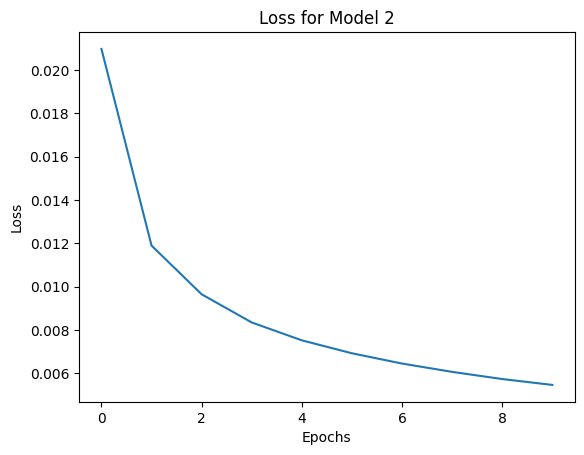

In [29]:
plt.plot(loss12)
plt.title('Loss for Model 2')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [30]:
model_pred = mnist_model_12.model_predict(x_train)
t = convert_to_binary(model_pred)
print('Accuracy for Model 2 in traning data set: ',accuracy_MNist(y_train , t))

Accuracy for Model 2 in traning data set:  97.27592592592592


Model 3 with learning rate 0.01 and TanhActivation functions

In [31]:
mnist_model_13 = Sequential()  
sig_model_mn = Tanh_Activation_Function()
mnist_model_13.add(Linear_Layer(28*28, 40 ))              
mnist_model_13.add(Activation_Function_Layer(sig_model_mn.forward_pass_propgation, sig_model_mn.backward_pass_propgation)) 

mnist_model_13.add(Linear_Layer(40, 10))                 
mnist_model_13.add(Activation_Function_Layer(sig_model_mn.forward_pass_propgation, sig_model_mn.backward_pass_propgation))  



In [32]:
mnist_model_13.applyLossFunction(calculateMeanSquaredError, calculateMSEGradient)
loss13 = mnist_model_13.fit(x_train, y_train, epochs=10, lr=0.1)

mnist_model_13.retrieveModelWeights()

mnist_model_13.savingModel()
optimizedMnistWeights = mnist_model_13.loadingModel()
print("Optimized weights for Mnist problem:", optimizedMnistWeights)

Epoch no. 1/10  Error = 0.023770
Epoch no. 6/10  Error = 0.013752
Optimized weights for Mnist problem: [array([[-0.02809791,  0.00346596, -0.01131616, ..., -0.01275127,
        -0.02090682, -0.01822816],
       [-0.04191252,  0.00974119,  0.04278796, ...,  0.01733992,
         0.10785595, -0.01731582],
       [ 0.09234326, -0.05635328, -0.01317023, ..., -0.07046319,
         0.05736211, -0.00603513],
       ...,
       [-0.03091382,  0.03687527, -0.02626023, ..., -0.02131642,
         0.00095276, -0.02442924],
       [ 0.03603653, -0.00973749, -0.01350423, ..., -0.00729038,
         0.01967792, -0.05927115],
       [-0.00545571, -0.02559106, -0.0174834 , ...,  0.02428095,
         0.03682754, -0.01413523]])]


Text(0.5, 0, 'Epochs')

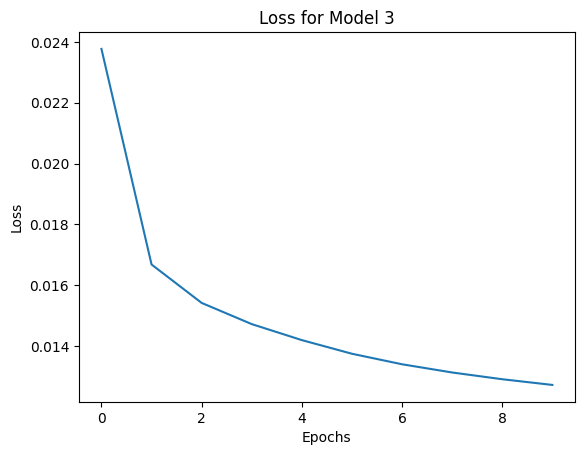

In [33]:
plt.plot(loss13)
plt.title('Loss for Model 3')
plt.ylabel('Loss')
plt.xlabel('Epochs')

In [34]:
model_pred = mnist_model_13.model_predict(x_train)
t = convert_to_binary(model_pred)
print('Accuracy for Model 3 in traning data set',accuracy_MNist(y_train , t))

Accuracy for Model 3 in traning data set 94.79444444444445


Model performances on the test data sets


Epoch no. 1/10  Error = 0.005003
Epoch no. 6/10  Error = 0.003456
Accuracy on Model 1 on test dataset 98.5


Text(0.5, 0, 'Epochs')

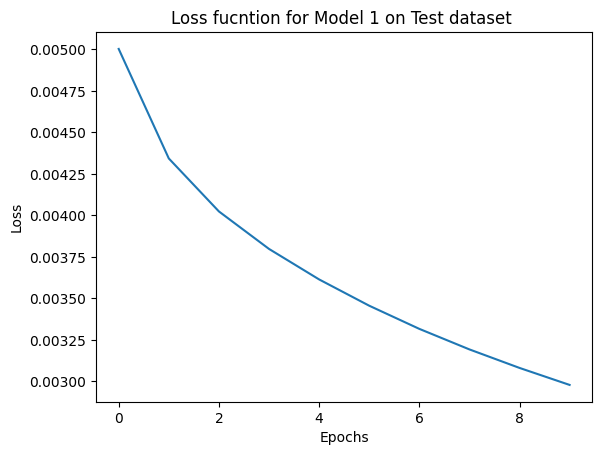

In [35]:
mnist_model_11.applyLossFunction(calculateMeanSquaredError, calculateMSEGradient)
loss111 = mnist_model_11.fit(x_test, y_test, epochs=10, lr=0.01)
model_pred = mnist_model_11.model_predict(x_test)
t = convert_to_binary(model_pred)
print("Accuracy on Model 1 on test dataset", accuracy_MNist(y_test , t))
plt.plot(loss111)
plt.title('Loss fucntion for Model 1 on Test dataset ')
plt.ylabel('Loss')
plt.xlabel('Epochs')


Epoch no. 1/20  Error = 0.007495
Epoch no. 6/20  Error = 0.003554
Epoch no. 11/20  Error = 0.002464
Epoch no. 16/20  Error = 0.002012
Accuracy on Model 2:  99.15


Text(0.5, 0, 'Total epochs')

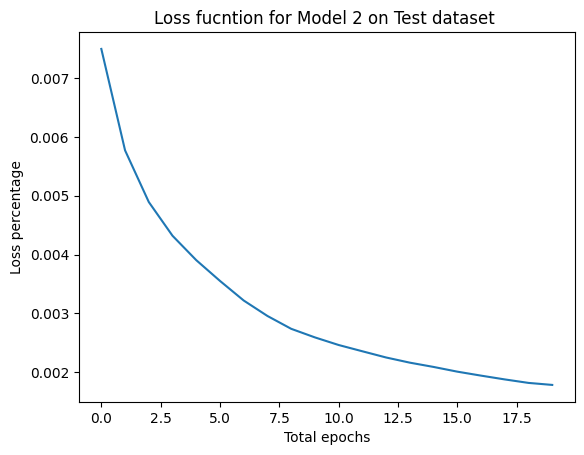

In [36]:
mnist_model_12.applyLossFunction(calculateMeanSquaredError, calculateMSEGradient)
loss222 = mnist_model_12.fit(x_test, y_test, epochs=20, lr=0.1)

model_pred = mnist_model_12.model_predict(x_test)
t = convert_to_binary(model_pred)
print("Accuracy on Model 2: ", accuracy_MNist(y_test , t))

plt.plot(loss222)
plt.title('Loss fucntion for Model 2 on Test dataset ')
plt.ylabel('Loss percentage')
plt.xlabel('Total epochs')

Epoch no. 1/20  Error = 0.013236
Epoch no. 6/20  Error = 0.010596
Epoch no. 11/20  Error = 0.009575
Epoch no. 16/20  Error = 0.008913
Accuracy on Model 3:  96.44


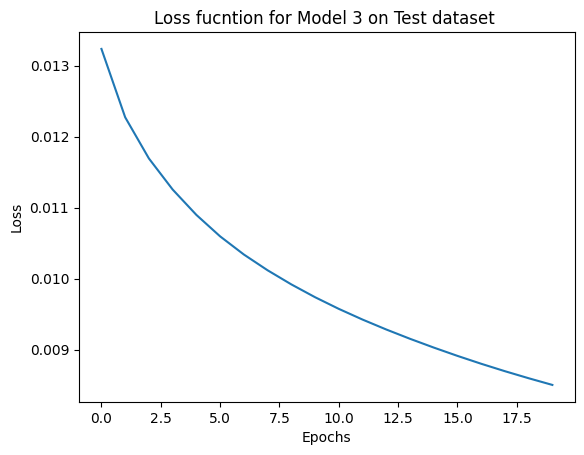

In [37]:
mnist_model_13.applyLossFunction(calculateMeanSquaredError, calculateMSEGradient)
loss333 = mnist_model_13.fit(x_test, y_test, epochs=20, lr=0.1)
plt.plot(loss333)
plt.title('Loss fucntion for Model 3 on Test dataset ')
plt.ylabel('Loss')
plt.xlabel('Epochs')
model_pred = mnist_model_13.model_predict(x_test)
t = convert_to_binary(model_pred)
print("Accuracy on Model 3: ", accuracy_MNist(y_test , t))